In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [16]:
palette = {"Secure": "#00B2CA", "Insecure": "#F79256"}

In [17]:
data_figure_A = pd.read_csv("../data_for_figures/data_figure_A.csv")
data_figure_B = pd.read_csv("../data_for_figures/data_figure_B.csv")
data_figure_C = pd.read_csv("../data_for_figures/data_figure_C.csv")
data_figure_D = pd.read_csv("../data_for_figures/data_figure_D.csv")

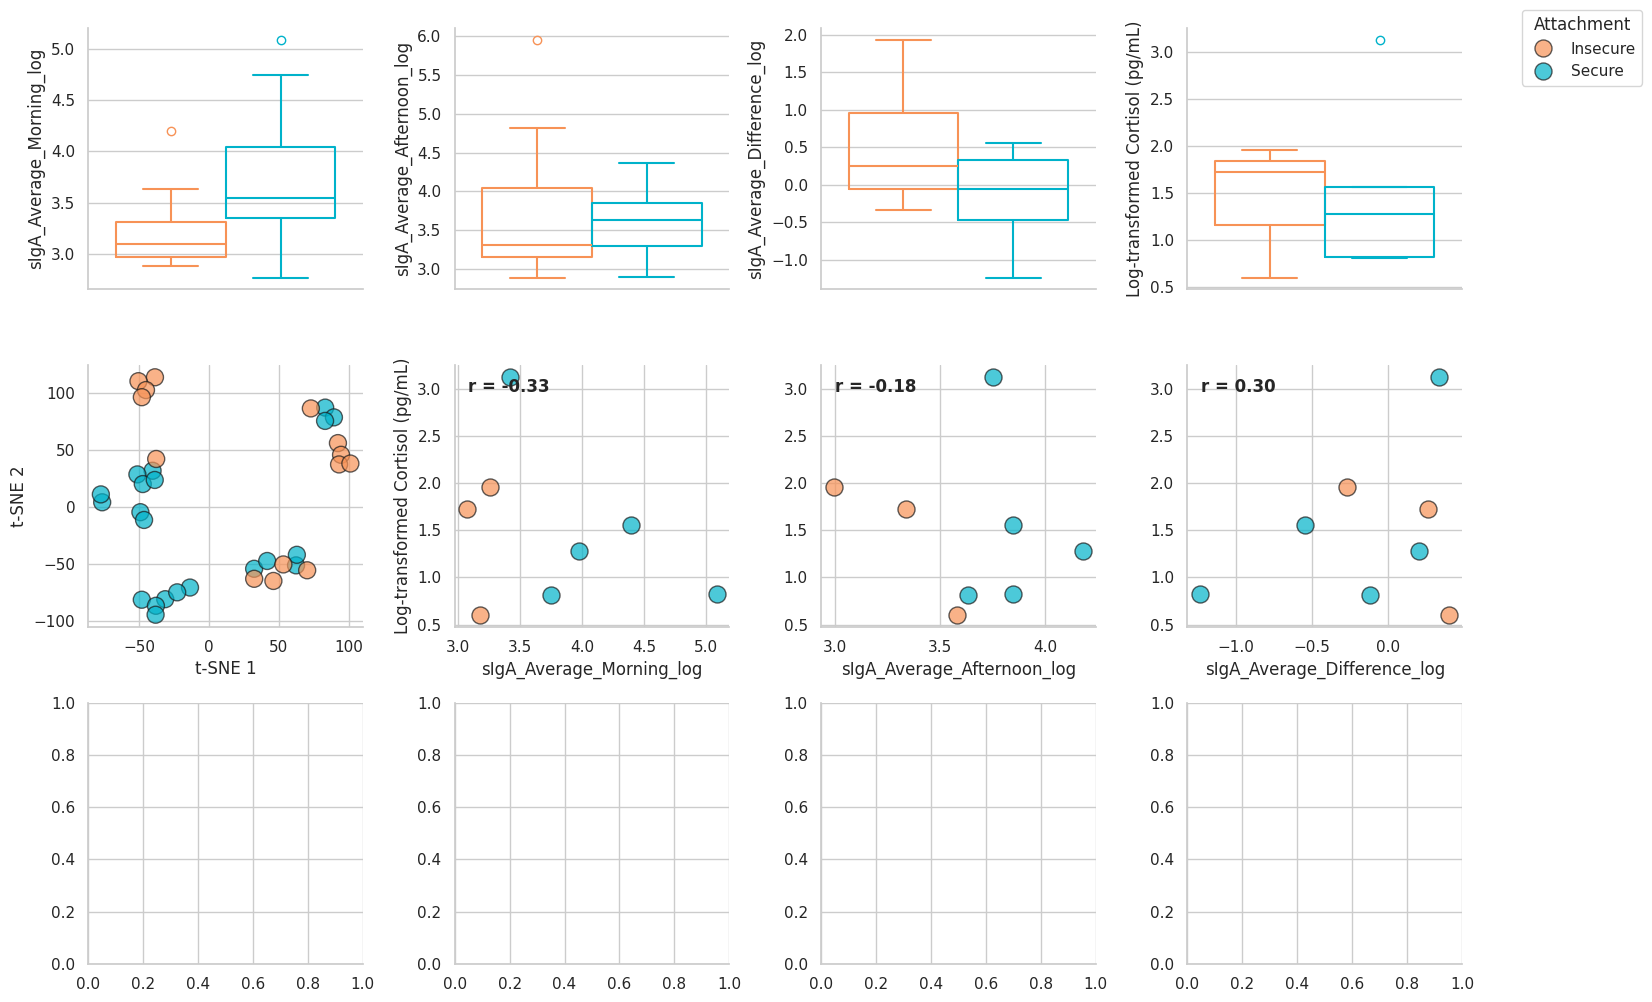

In [31]:
sns.set(style="whitegrid", font_scale=1)

fig, axes = plt.subplots(3, 4, figsize=(15, 10))

# ploting first row
sns.boxplot(
    data=data_figure_A, 
    y="sIgA_Average_Morning_log", 
    hue="Attachment", 
    ax=axes[0][0], 
    fill=False,
    palette=palette,
    legend=False)

sns.boxplot(
    data=data_figure_A, 
    y="sIgA_Average_Afternoon_log", 
    hue="Attachment", 
    ax=axes[0][1], 
    fill=False, 
    palette=palette,
    legend=False)

sns.boxplot(
    data=data_figure_A, 
    y="sIgA_Average_Difference_log", 
    hue="Attachment", 
    ax=axes[0][2], 
    palette=palette,
    legend=False,
    fill=False)

sns.boxplot(
    data=data_figure_C, 
    y="Log-transformed Cortisol (pg/mL)", 
    hue="Attachment", 
    ax=axes[0][3], 
    fill=False,
    palette=palette, 
    legend=False)

sns.despine()

# ploting second row
sns.scatterplot(
    ax=axes[1][0],
    data=data_figure_B,
    x="p_1",
    y="p_2",
    hue="Attachment",
    palette=palette,
    alpha=0.7,
    s=150,
    edgecolor='k'
)

axes[1][0].set_xlabel("t-SNE 1")
axes[1][0].set_ylabel("t-SNE 2")

handles, labels = axes[1][0].get_legend_handles_labels()
fig.legend(handles, labels, title="Attachment", bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)

axes[1][0].get_legend().remove()

x_vars = ["sIgA_Average_Morning_log", "sIgA_Average_Afternoon_log", "sIgA_Average_Difference_log"]
y_var = "Log-transformed Cortisol (pg/mL)"


for i, x in enumerate(x_vars):
    ax = axes[1][i+1]

    for attachment, group in data_figure_D.groupby("Attachment"):
        ax.scatter(
            group[x], group[y_var],
            label=attachment if i == 0 else "", 
            alpha=0.7,
            s=150,
            edgecolor='k',
            color=palette[attachment]
        )
    
    ax.set_xlabel(x, fontsize=12)
    if i == 0:
        ax.set_ylabel(y_var, fontsize=12)
    else:
        ax.set_ylabel("")

    r, _ = pearsonr(data_figure_D[x], data_figure_D[y_var])
    ax.text(
        0.05, 0.9, f"r = {r:.2f}",
        transform=ax.transAxes,
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()

In [37]:
data_figure_E = pd.read_csv("../data_for_figures/data_figure_E.csv")
data_figure_E

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_names
0,-1.052,1.162,-3.450,1.175,0.049,0.030,562.0,766.0,1.01,beta_siga_morning
1,-0.009,1.206,-2.262,2.555,0.051,0.030,550.0,775.0,1.01,beta_siga_afternoon
2,1.063,1.275,-1.347,3.713,0.053,0.032,569.0,741.0,1.01,beta_siga_diff


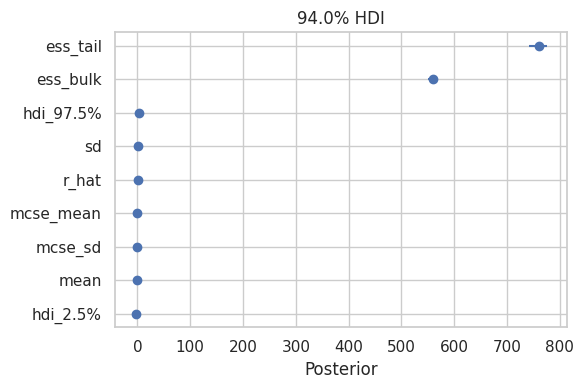

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from typing import Tuple


def hdi_of_samples(x: np.ndarray, hdi_prob: float = 0.94) -> Tuple[float, float]:
    x = np.asarray(x).astype(float)
    x = x[~np.isnan(x)]
    if x.size == 0:
        return (np.nan, np.nan)
    x_sorted = np.sort(x)
    n = x_sorted.size
    interval_idx_inc = int(np.floor(hdi_prob * n))
    if interval_idx_inc < 1:
        return (np.nan, np.nan)
    n_intervals = n - interval_idx_inc
    if n_intervals <= 0:
        return (x_sorted[0], x_sorted[-1])
    interval_width = x_sorted[interval_idx_inc:] - x_sorted[:n - interval_idx_inc]
    min_idx = np.argmin(interval_width)
    hdi_min = x_sorted[min_idx]
    hdi_max = x_sorted[min_idx + interval_idx_inc]
    return float(hdi_min), float(hdi_max)

# Try to infer format
cols_lower = {c.lower(): c for c in data_figure_E.columns}
long_param_col = None
long_value_col = None

# Candidate names for parameter and value
param_candidates = ["parameter", "param", "var", "variable", "name"]
value_candidates = ["value", "val", "sample", "draw", "posterior", "y"]

for pc in param_candidates:
    if pc in cols_lower:
        long_param_col = cols_lower[pc]
        break

for vc in value_candidates:
    if vc in cols_lower:
        long_value_col = cols_lower[vc]
        break

# Identify chain/draw columns to drop in wide format
drop_candidates = [c for c in data_figure_E.columns if c.lower() in {"chain", "draw", "sample"}]

summary_rows = []

if long_param_col and long_value_col:
    # Long format
    # Group by parameter and compute stats
    for param, sub in data_figure_E.groupby(long_param_col):
        x = pd.to_numeric(sub[long_value_col], errors="coerce").dropna().values
        if x.size == 0:
            continue
        hdi_lo, hdi_hi = hdi_of_samples(x, 0.94)
        summary_rows.append({
            "parameter": str(param),
            "mean": float(np.mean(x)),
            "median": float(np.median(x)),
            "hdi_lower": hdi_lo,
            "hdi_upper": hdi_hi,
            "hdi_prob": 0.94,
            "n": int(x.size)
        })
else:
    # Wide format: numeric columns except known metadata
    _df = data_figure_E.drop(columns=drop_candidates, errors="ignore")
    # Keep only numeric columns
    numeric_cols = [c for c in _df.columns if pd.api.types.is_numeric_dtype(_df[c])]
    # If none numeric, try to coerce everything
    if not numeric_cols:
        for c in _df.columns:
            _df[c] = pd.to_numeric(_df[c], errors="coerce")
        numeric_cols = [c for c in _df.columns if pd.api.types.is_numeric_dtype(_df[c])]
    # Build summary per numeric column
    for c in numeric_cols:
        x = _df[c].astype(float).dropna().values
        if x.size == 0:
            continue
        hdi_lo, hdi_hi = hdi_of_samples(x, 0.94)
        summary_rows.append({
            "parameter": str(c),
            "mean": float(np.mean(x)),
            "median": float(np.median(x)),
            "hdi_lower": hdi_lo,
            "hdi_upper": hdi_hi,
            "hdi_prob": 0.94,
            "n": int(x.size)
        })

summary = pd.DataFrame(summary_rows)
# Sort by mean for a nice forest plot ordering
if not summary.empty:
    summary = summary.sort_values("mean").reset_index(drop=True)

# Create forest plot from summary
fig = plt.figure(figsize=(6, max(2.5, 0.45 * max(1, len(summary)))))
ax = plt.gca()

y = np.arange(len(summary))
# Horizontal lines for HDIs
for i, row in summary.iterrows():
    ax.hlines(y=i, xmin=row["hdi_lower"], xmax=row["hdi_upper"])
# Points at means
ax.plot(summary["mean"], y, "o")

ax.set_yticks(y)
ax.set_yticklabels(summary["parameter"] if len(summary) > 0 else [])
ax.set_xlabel("Posterior")
ax.set_title("94.0% HDI")

plt.tight_layout()